In [1]:
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

In [2]:
exp_df = pd.read_csv('../outExp.csv')

In [3]:
exp_df_batch = exp_df[
    (exp_df['batch_name'] == 'Comparable') &
    (exp_df['LED_trial'].isin([np.nan, 0]))
]
print(len(exp_df_batch))

118869


In [4]:
df_valid_and_aborts = exp_df_batch[
    (exp_df_batch['success'].isin([1,-1])) |
    (exp_df_batch['abort_event'] == 3)
]
print(f'{len(df_valid_and_aborts)} valid and abort events')

90298 valid and abort events


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Filter to aborts only
aborts = df_valid_and_aborts[df_valid_and_aborts['abort_event'] == 3]

animals = aborts['animal'].unique()
sessions = aborts['session'].unique()

with PdfPages('aborts_trial_distributions.pdf') as pdf:
    for animal in animals:
        animal_aborts = aborts[aborts['animal'] == animal]
        for session in animal_aborts['session'].unique():
            session_aborts = animal_aborts[animal_aborts['session'] == session]
            trials_lt = session_aborts[session_aborts['TotalFixTime'] < 0.3]['trial']
            trials_gt = session_aborts[session_aborts['TotalFixTime'] > 0.3]['trial']

            # Determine bin range for this plot
            all_trials = pd.concat([trials_lt, trials_gt])
            if all_trials.empty:
                continue
            min_trial = all_trials.min()
            max_trial = all_trials.max()
            bins = np.arange(min_trial, max_trial + 2)  # +2 so last trial is included

            plt.figure(figsize=(8, 5))
            plt.hist(trials_lt, bins=bins, alpha=0.7, label='TotalFixTime < 0.3')
            plt.hist(trials_gt, bins=bins, alpha=0.7, label='TotalFixTime > 0.3')
            plt.title(f'Animal {animal}, Session {session}: Trial Number Distribution (Aborts)')
            plt.xlabel('Trial Number')
            plt.ylabel('Count')
            plt.legend()
            plt.tight_layout()
            pdf.savefig()  # saves the current figure into the pdf
            plt.close()

Text(0.5, 1.0, 'aborts')

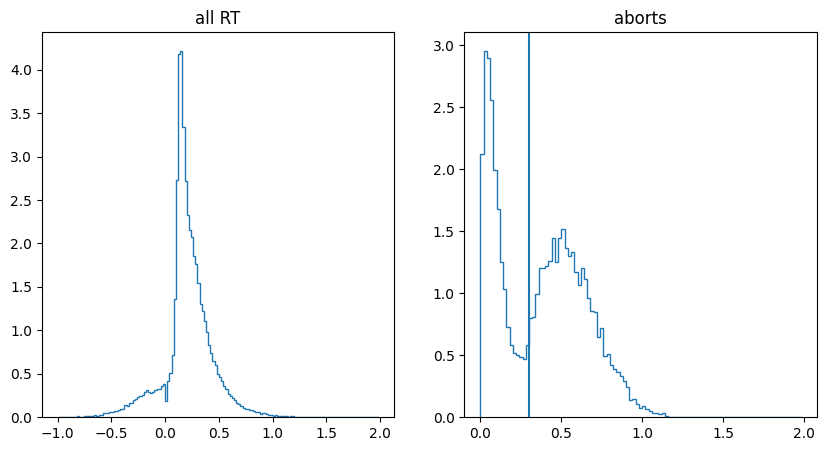

In [8]:
# plot RTD
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
bins = np.arange(-1,2,0.02)
plt.hist(df_valid_and_aborts['RTwrtStim'], density=True, bins=bins, histtype='step');
plt.title('all RT')

plt.subplot(1,2,2)
df_aborts = df_valid_and_aborts[df_valid_and_aborts['abort_event'] == 3]
bins = np.arange(0,2,0.02)
# plt.hist(df_aborts['RTwrtStim'] + df_aborts['intended_fix'], density=True, bins=bins, histtype='step');
plt.hist(df_aborts['TotalFixTime'], density=True, bins=bins, histtype='step');

plt.axvline(0.3)
plt.title('aborts')



In [13]:
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

# Ensure the pdfs directory exists (one level up from current directory)
pdf_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'pdfs'))
os.makedirs(pdf_dir, exist_ok=True)
pdf_path = os.path.join(pdf_dir, 'animal_abort_rasters.pdf')

# Filter to aborts only
aborts = df_valid_and_aborts[df_valid_and_aborts['abort_event'] == 3]

with PdfPages(pdf_path) as pdf:
    for animal in aborts['animal'].unique():
        animal_aborts = aborts[aborts['animal'] == animal]
        # Sort sessions in ascending order
        sessions = sorted(animal_aborts['session'].unique())
        n_sessions = len(sessions)
        plt.figure(figsize=(5, max(1.5, n_sessions*0.25)))  # further reduced size
        for i, session in enumerate(sessions):
            session_aborts = animal_aborts[animal_aborts['session'] == session]
            trials = session_aborts['trial'].values
            total_fix = session_aborts['TotalFixTime'].values
            # Normalize trial numbers within this session
            if len(trials) == 0:
                continue
            min_trial = trials.min()
            max_trial = trials.max()
            if max_trial == min_trial:
                norm_trials = [0.5]*len(trials)
            else:
                norm_trials = (trials - min_trial) / (max_trial - min_trial)
            for x, tf in zip(norm_trials, total_fix):
                color = 'red' if tf < 0.3 else 'green'
                plt.scatter(x, i, color=color, s=10)  # smaller marker and less vertical space
        plt.yticks(range(n_sessions), [f"Session {s}" for s in sessions])
        plt.gca().invert_yaxis()  # so session 0 is at the top
        plt.xlabel('Normalized Trial Number')
        plt.ylabel('Session')
        plt.title(f'Aborts RT: {animal},R:<0.3')
        plt.tight_layout()
        pdf.savefig()
        plt.close()

print(f"Saved all raster plots to {pdf_path}")

Saved all raster plots to /home/rlab/raghavendra/ddm_data/pdfs/animal_abort_rasters.pdf


In [18]:
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

# Ensure the pdfs directory exists (one level up from current directory)
pdf_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'pdfs'))
os.makedirs(pdf_dir, exist_ok=True)
pdf_path = os.path.join(pdf_dir, 'all_trials_raster_all_animals.pdf')

with PdfPages(pdf_path) as pdf:
    for animal in df_valid_and_aborts['animal'].unique():
        animal_df = df_valid_and_aborts[df_valid_and_aborts['animal'] == animal]
        sessions = sorted(animal_df['session'].unique())
        n_sessions = len(sessions)
        plt.figure(figsize=(12, max(2, n_sessions*0.18)))  # even closer rows
        for i, session in enumerate(sessions):
            session_df = animal_df[animal_df['session'] == session]
            trials = session_df['trial'].values
            total_fix = session_df['TotalFixTime'].values
            abort_event = session_df['abort_event'].values
            rtwrtstim = session_df['RTwrtStim'].values
            # Normalize trial numbers within this session
            if len(trials) == 0:
                continue
            min_trial = trials.min()
            max_trial = trials.max()
            if max_trial == min_trial:
                norm_trials = [0.5]*len(trials)
            else:
                norm_trials = (trials - min_trial) / (max_trial - min_trial)
            for x, tf, ab, rt in zip(norm_trials, total_fix, abort_event, rtwrtstim):
                if ab == 3 and tf < 0.3:
                    color = 'red'
                    size = 8  # 2x bigger than green
                elif rt > 1:
                    color = 'blue'
                    size = 8  # 2x bigger than green
                else:
                    color = 'green'
                    size = 4
                plt.scatter(x, i, color=color, s=size)
        plt.yticks(range(n_sessions), [f"Session {s}" for s in sessions])
        plt.gca().invert_yaxis()
        plt.xlabel('Normalized Trial Number')
        plt.ylabel('Session')
        plt.title(f'All Trials Raster: {animal}\nRed: abort_event==3 & Fix<0.3, Blue: RTwrtStim>1, Green: other')
        plt.tight_layout()
        pdf.savefig()
        plt.close()

print(f"Saved raster plots for all animals to {pdf_path}")


Saved raster plots for all animals to /home/rlab/raghavendra/ddm_data/pdfs/all_trials_raster_all_animals.pdf


In [ ]:
num_nan = df_valid_and_aborts[df_valid_and_aborts['abort_event'] == 3]['RTwrtStim'].isna().sum()
print("Number of NaN in RTwrtStim where abort_event == 3:", num_nan)

In [ ]:
len(df_valid_and_aborts), len(df_valid_and_aborts[df_valid_and_aborts['success'].isin([1,-1])])

In [ ]:
num_nan = exp_df[exp_df['abort_event'] == 3]['RTwrtStim'].isna().sum()
print("Number of NaN in RTwrtStim where abort_event == 3:", num_nan)

In [ ]:
exp_df.columns

In [ ]:
aborts_df = df_valid_and_aborts[df_valid_and_aborts['abort_event'] == 3]

In [ ]:
aborts_df_valid_rt = aborts_df[aborts_df['RTwrtStim'].notna()]

In [ ]:
aborts_df_nan_rt = aborts_df[aborts_df['RTwrtStim'].isna()]

In [ ]:
key_cols = ['box', 'animal', 'session', 'session_type', 'training_level']

for idx, row in aborts_df_nan_rt.iterrows():
    # Find matching rows in aborts_df_valid_rt
    mask = (aborts_df_valid_rt[key_cols] == row[key_cols]).all(axis=1)
    matching = aborts_df_valid_rt[mask]
    if not matching.empty:
        for match_idx, match_row in matching.iterrows():
            diffs = []
            for col in aborts_df_nan_rt.columns:
                val1 = row[col]
                val2 = match_row[col]
                if not (pd.isna(val1) and pd.isna(val2)) and val1 != val2:
                    diffs.append((col, val1, val2))
            print(f"\nRow in aborts_df_nan_rt (index {idx}) matches row in aborts_df_valid_rt (index {match_idx}) on {key_cols}")
            if diffs:
                print("  Columns with different values:")
                for col, v1, v2 in diffs:
                    print(f"    {col}: nan_rt={v1}, valid_rt={v2}")
            else:
                print("  All other columns are identical.")
    else:
        print(f"\nNo match found in aborts_df_valid_rt for row in aborts_df_nan_rt (index {idx}) with {key_cols} values: {row[key_cols].to_dict()}")

In [ ]:
aborts_df_nan_rt['trial']

In [ ]:
for batch in exp_df['batch_name'].unique():
    batch_df = exp_df[exp_df['batch_name'] == batch]
    for session_type in batch_df['session_type'].dropna().unique():
        session_type_df = batch_df[batch_df['session_type'] == session_type]
        for session in session_type_df['session'].unique():
            session_df = session_type_df[session_type_df['session'] == session]
            # abort = 3 and RT nan
            mask = (session_df['abort_event'] == 3) & (session_df['RTwrtStim'].isna())
            if mask.any():
                trial_nums = session_df[mask]['trial'].values
                trial_range = (session_df['trial'].min(), session_df['trial'].max())
                print(f"batch_name: {batch}, session_type: {session_type}, session: {session}")
                print(f"  Trials with abort_event==3 and RTwrtStim NaN: {trial_nums}")
                print(f"  Trial number range for session: {trial_range}")
                print('-----')


In [6]:
for batch in exp_df['batch_name'].unique():
    batch_df = exp_df[exp_df['batch_name'] == batch]
    for session_type in batch_df['session_type'].dropna().unique():
        session_type_df = batch_df[batch_df['session_type'] == session_type]
        for session in session_type_df['session'].unique():
            session_df = session_type_df[session_type_df['session'] == session]
            # abort = 3 and RT nan
            mask = (session_df['abort_event'] == 3) & (session_df['RTwrtStim'].isna())
            if mask.any():
                trial_nums = session_df[mask]['trial'].values
                print(f"batch_name: {batch}, session_type: {session_type}, session: {session}")
                print(f"  Trials with abort_event==3 and RTwrtStim NaN: {trial_nums}")
                # For each trial, print its block and the block of trial+1
                for trial in trial_nums:
                    block = session_df[session_df['trial'] == trial]['block'].iloc[0]
                    print(f"    trial: {trial}, block: {block}")
                    # Find the block of trial+1 (if it exists)
                    next_trial_row = exp_df[(exp_df['trial'] == trial + 1) & 
                                            (exp_df['batch_name'] == batch) & 
                                            (exp_df['session_type'] == session_type)]
                    if not next_trial_row.empty:
                        next_block = next_trial_row.iloc[0]['block']
                        print(f"    trial+1: {trial+1}, block: {next_block}")
                    else:
                        print(f"    trial+1: {trial+1} not found in this batch/session_type")

batch_name: Comparable, session_type: 6.0, session: 73
  Trials with abort_event==3 and RTwrtStim NaN: [58188]
    trial: 58188, block: 1
    trial+1: 58189, block: 1
batch_name: Comparable, session_type: 6.0, session: 86
  Trials with abort_event==3 and RTwrtStim NaN: [68453]
    trial: 68453, block: 4
    trial+1: 68454, block: 3
batch_name: SD, session_type: 1.0, session: 12
  Trials with abort_event==3 and RTwrtStim NaN: [8654 8618]
    trial: 8654, block: 7
    trial+1: 8655, block: 1
    trial: 8618, block: 7
    trial+1: 8619, block: 1
batch_name: LED1, session_type: 1.0, session: 45
  Trials with abort_event==3 and RTwrtStim NaN: [21869]
    trial: 21869, block: 2
    trial+1: 21870, block: 3
batch_name: LED1, session_type: 1.0, session: 64
  Trials with abort_event==3 and RTwrtStim NaN: [26660]
    trial: 26660, block: 1
    trial+1: 26661, block: 2
batch_name: LED1, session_type: 1.0, session: 73
  Trials with abort_event==3 and RTwrtStim NaN: [34492]
    trial: 34492, block:

In [7]:
for batch in exp_df['batch_name'].unique():
    batch_df = exp_df[exp_df['batch_name'] == batch]
    for session_type in batch_df['session_type'].dropna().unique():
        session_type_df = batch_df[batch_df['session_type'] == session_type]
        for session in session_type_df['session'].unique():
            session_df = session_type_df[session_type_df['session'] == session]
            # abort = 3 and RT nan
            mask = (session_df['abort_event'] == 3) & (session_df['RTwrtStim'].isna())
            if mask.any():
                trial_nums = session_df[mask]['trial'].values
                print(f"batch_name: {batch}, session_type: {session_type}, session: {session}")
                print(f"  Trials with abort_event==3 and RTwrtStim NaN: {trial_nums}")
                # For each trial, print its block and the block of trial+1
                for trial in trial_nums:
                    trial_row = session_df[session_df['trial'] == trial]
                    block = trial_row['block'].iloc[0]
                    print(f"    trial: {trial}, block: {block}")
                    # Find the block and other columns of trial+1 (if it exists)
                    next_trial_row = exp_df[(exp_df['trial'] == trial + 1) & 
                                            (exp_df['batch_name'] == batch) & 
                                            (exp_df['session_type'] == session_type)]
                    if not next_trial_row.empty:
                        next_block = next_trial_row.iloc[0]['block']
                        print(f"    trial+1: {trial+1}, block: {next_block}")

                        # Compare all columns
                        diffs = []
                        for col in exp_df.columns:
                            val1 = trial_row.iloc[0][col]
                            val2 = next_trial_row.iloc[0][col]
                            # Handle nan comparison
                            if pd.isna(val1) and pd.isna(val2):
                                continue
                            if val1 != val2:
                                diffs.append(col)
                        if diffs:
                            print(f"    Columns that differ between trial {trial} and trial {trial+1}: {diffs}")
                        else:
                            print(f"    No other columns differ between trial {trial} and trial {trial+1}.")
                    else:
                        print(f"    trial+1: {trial+1} not found in this batch/session_type")

batch_name: Comparable, session_type: 6.0, session: 73
  Trials with abort_event==3 and RTwrtStim NaN: [58188]
    trial: 58188, block: 1
    trial+1: 58189, block: 1
    Columns that differ between trial 58188 and trial 58189: ['session', 'trial', 'trials_per_block', 'ABL', 'reward_open_L', 'reward_open_R', 'trial_start', 'trial_end', 'trial_duration', 'ILD', 'ILD_index', 'abort_event', 'block_perf', 'block_ar', 'repeat_trial', 'timed_ITI', 'intended_fix', 'left_amp', 'right_amp', 'waveformR', 'waveformL', 'absILD', 'FixAbort', 'outcome']
batch_name: Comparable, session_type: 6.0, session: 86
  Trials with abort_event==3 and RTwrtStim NaN: [68453]
    trial: 68453, block: 4
    trial+1: 68454, block: 3
    Columns that differ between trial 68453 and trial 68454: ['box', 'animal', 'session', 'block', 'trial', 'trials_per_block', 'reward_open_L', 'reward_open_R', 'trial_start', 'trial_end', 'trial_duration', 'ILD', 'ILD_index', 'success', 'abort_event', 'block_perf', 'block_ar', 'repeat